# Review Tool Calls

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). A common pattern is to add some human in the loop step after certain tool calls. These tool calls often lead to either a function call or saving of some information. Examples include:

- A tool call to execute SQL, which will then be run by the tool
- A tool call to generate a summary, which will then be saved to the State of the graph

Note that using tool calls is common **whether actually calling tools or not**.

There are typically a few different interactions you may want to do here:

1. Approve the tool call and continue
2. Modify the tool call manually and then continue
3. Give natural language feedback, and then pass that back to the agent instead of continuing

We can implement this in LangGraph using a [breakpoint](https://langchain-ai.github.io/langgraphjs/how-tos/breakpoints/): breakpoints allow us to interrupt graph execution before a specific step. At this breakpoint, we can manually update the graph state taking one of the three options above

## Setup

First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage

Let's set up a very simple graph that facilitates this.
First, we will have an LLM call that decides what action to take.
Then we go to a human node. This node actually doesn't do anything - the idea is that we interrupt before this node and then apply any updates to the state.
After that, we check the state and either route back to the LLM or to the correct tool.

Let's see this in action!

In [4]:
import { MessagesAnnotation, StateGraph, START, END, MemorySaver } from "@langchain/langgraph";
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from '@langchain/core/tools';
import { z } from 'zod';
import { ToolMessage, AIMessage, isAIMessage } from '@langchain/core/messages';
import { ToolNode } from '@langchain/langgraph/prebuilt'
import { get } from "http";

const getWeather = tool((input) => {
    const city = input.city;
    console.log("----");
    console.log(`Searching for: ${city}`);
    console.log("----");
    return "Sunny!";
}, {
    name: 'get_weather',
    description: 'Call to get the current weather.',
    schema: z.object({
        city: z.string().describe("City to get the weather for."),
    })
})

const tools = [getWeather];

const StateAnnotation = MessagesAnnotation // list of messages


const model = new ChatAnthropic({ model: "claude-3-5-sonnet-20240620" });
const modelWithTools = model.bindTools([getWeather]);

const callLLM = async (state: typeof StateAnnotation.State) => {
  const response = await modelWithTools.invoke(state.messages);
  return { messages: [response] };
}

const runTool = async (state: typeof StateAnnotation.State) => {
  const newMessages: ToolMessage[] = [];
  const tools = { "get_weather" : getWeather };

  const lastMessage: AIMessage = state.messages[state.messages.length - 1];
  const toolCalls = lastMessage.tool_calls;

  if (toolCalls) {
    for (const toolCall of toolCalls) {
        const tool = tools[toolCall.name];
        const result = await tool.invoke(toolCall.args);
        newMessages.push(new ToolMessage({
            name: toolCall.name,
            content: result,
            tool_call_id: toolCall.id ?? "",
        }));
    }
  }

  console.log(newMessages);
  return { messages: newMessages };
}

const humanReviewNode = async (state: typeof StateAnnotation.State) => {
  // Node waits for human input and then goes to next node
  return { messages: [] };
};

function routeAfterLLM(state: typeof StateAnnotation.State): typeof END | "human_review_node" {
  const lastMessage: AIMessage = state.messages[state.messages.length - 1];
  if (lastMessage.tool_calls?.length === 0) {
      return END;
  } else {
      return "human_review_node";
  }
}

function routeAfterHuman(state: typeof StateAnnotation.State): "tools" | "llm" {
  if (isAIMessage(state.messages[state.messages.length - 1])) {
      return "tools";
  } else {
      return "llm";
  }
}

const workflow = new StateGraph(StateAnnotation)
    // Define the two nodes we will cycle between
    .addNode("llm", callLLM)
    .addNode("tools", new ToolNode(tools))
    .addNode("human_review_node", humanReviewNode)
    .addEdge(START, "llm")
    .addConditionalEdges(
        "llm",
        routeAfterLLM,
        ["human_review_node", END]
    )
    .addConditionalEdges(
        "human_review_node",
        routeAfterHuman,
        ["tools", "llm"]
    )
    .addEdge("tools", "llm");

// Setup memory
const memory = new MemorySaver();

const graph = workflow.compile({ interruptBefore: ["human_review_node"], checkpointer: memory });

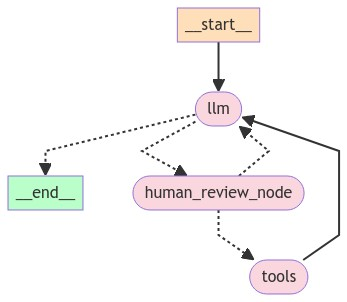

In [5]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Example with no review

Let's look at an example when no review is required (because no tools are called)

In [167]:
let inputs = { messages: [{ role: "user", content: "hi!" }] };
let config = { configurable: { thread_id: "1" }, streamMode: "values" as const };

let stream = await graph.stream({
    messages: [inputs]
}, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
hi!
================================ ai Message (1) =================================
Hello! Welcome. How can I assist you today? Is there anything specific you'd like to know or any information you need help with?


If we check the state, we can see that it is finished, since there are no next steps to take:

In [168]:
let state = await graph.getState(config);
console.log(state.next);

[]


## Example of approving tool

Let's now look at what it looks like to approve a tool call

In [169]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "2" }, streamMode: "values" as const };

stream = await graph.stream({
    messages: [inputs]
}, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I can help you check the weather in San Francisco. To get this information, I'll need to use the weather tool available to me. Let me fetch that data for you."
  },
  {
    type: 'tool_use',
    id: 'toolu_01GeZBgMXnDRxkx9okfxXutD',
    name: 'get_weather',
    input: { city: 'San Francisco' }
  }
]


If we now check, we can see that it is waiting on human review

In [170]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To approve the tool call, we can just continue the thread with no edits. To do this, we just create a new run with no inputs.

In [171]:
stream = await graph.stream(null, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I can help you check the weather in San Francisco. To get this information, I'll need to use the weather tool available to me. Let me fetch that data for you."
  },
  {
    type: 'tool_use',
    id: 'toolu_01GeZBgMXnDRxkx9okfxXutD',
    name: 'get_weather',
    input: { city: 'San Francisco' }
  }
]
----
Searching for: San Francisco
----
[
  ToolMessage {
    "content": "Sunny!",
    "name": "get_weather",
    "additional_kwargs": {},
    "response_metadata": {},
    "tool_call_id": "toolu_01GeZBgMXnDRxkx9okfxXutD"
  }
]
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
Great news! The current weather in San Francisco is sunny. It's a beautiful day in the city by the bay. Is there anything else you'd like to know about the weather or any o

## Edit Tool Call

Let's now say we want to edit the tool call. E.g. change some of the parameters (or even the tool called!) but then execute that tool.

In [172]:
inputs = new HumanMessage("what's the weather in SF?");
config = { configurable: { thread_id: "3" }, streamMode: "values" as const };

stream = await graph.stream({
    messages: [inputs]
}, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'To get the weather information for San Francisco, I can use the `get_weather` function. Let me retrieve that information for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01A821WmpCsH3LhpAfFphp7r',
    name: 'get_weather',
    input: { city: 'San Francisco' }
  }
]


If we now check, we can see that it is waiting on human review

In [173]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To edit the tool call, we first need to update the state. We can do this by passing a message in with the **same** id of the message we want to overwrite. This will have the effect of **replacing** that old message. Note that this is only possible because of the **reducer** we are using that replaces messages with the same ID.

In [174]:
console.log("Current Tool Call ID:");
const currentContent = state.values["messages"][state.values["messages"].length-1].content;
const currrentID = state.values["messages"][state.values["messages"].length-1].id;
const toolCallID = state.values["messages"][state.values["messages"].length-1].tool_calls[0]["id"];
console.log(toolCallID);

let newMessage = new AIMessage({
    content: currentContent,
    tool_calls: [
        {
            id: toolCallID,
            name: "get_weather",
            args: {
                city: "San Francisco, USA"
            }
        }
    ],
    id: currrentID
});

// Update the state with the correct config, values, and specify the node we are acting as
await graph.updateState(config, { messages: [newMessage] }, "human_review_node");

stream = graph.stream(null, config);

// Let's now continue executing from here
for await (const event of await stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

Current Tool Call ID:
toolu_01WuLay5uwsGFigZ2zBXtXVG
----
Searching for: San Francisco, USA
----
[
  ToolMessage {
    "content": "Sunny!",
    "name": "get_weather",
    "additional_kwargs": {},
    "response_metadata": {},
    "tool_call_id": "toolu_01A821WmpCsH3LhpAfFphp7r"
  }
]
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
Based on the information I've received, the weather in San Francisco is sunny! It's a beautiful day in SF. Is there anything else you'd like to know about the weather or any other information I can help you with?


## Give feedback to a tool call

Sometimes, you may not want to execute a tool call, but you also may not want to ask the user to manually modify the tool call. In that case it may be better to get natural language feedback from the user. You can then insert these feedback as a mock **RESULT** of the tool call.

There are multiple ways to do this:

1. You could add a new message to the state (representing the "result" of a tool call)
2. You could add TWO new messages to the state - one representing an "error" from the tool call, other HumanMessage representing the feedback

Both are similar in that they involve adding messages to the state. The main difference lies in the logic AFTER the `human_node` and how it handles different types of messages.

For this example we will just add a single tool call representing the feedback. Let's see this in action!

In [175]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "4" }, streamMode: "values" as const };

stream = await graph.stream({
    messages: [inputs]
}, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I can help you check the weather in San Francisco. To get this information, I'll need to use the weather tool available to me. Let me do that for you right away."
  },
  {
    type: 'tool_use',
    id: 'toolu_01AxDZV7dHYgaDuHRhNS5HEL',
    name: 'get_weather',
    input: { city: 'San Francisco' }
  }
]


If we now check, we can see that it is waiting on human review

In [176]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To give feedback about the tool call, we first need to update the state. We can do this by passing a message in with the same **tool call id** of the tool call we want to respond to. Note that this is a **different** ID from above.

In [177]:
console.log("Current Tool Call ID:");
const toolCallId = state.values["messages"][state.values["messages"].length-1].tool_calls[0]["id"];
console.log(toolCallId);

newMessage = new ToolMessage({
    name: "get_weather",
    content: "User requested changes: pass in the most likely country this city is referring to as well",
    tool_call_id: toolCallId,
});

// Update the state with the correct config, values, and specify the node we are acting as
await graph.updateState(config, { messages: [newMessage] }, "human_review_node");

stream = graph.stream(null, config);

// Let's now continue executing from here
for await (const event of await stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

Current Tool Call ID:
toolu_01WuLay5uwsGFigZ2zBXtXVG
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the oversight. It seems the function requires more specific information. Let me try again with a more detailed request.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Q92V4EztnVv6qsUHABGP8V',
    name: 'get_weather',
    input: { city: 'San Francisco, USA' }
  }
]


We can see that we now get to another breakpoint - because it went back to the model and got an entirely new prediction of what to call. Let's now approve this one and continue.

In [179]:
state = await graph.getState(config);
console.log(state.next);

stream = await graph.stream(null, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

[ 'human_review_node' ]
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the oversight. It seems the function requires more specific information. Let me try again with a more detailed request.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Q92V4EztnVv6qsUHABGP8V',
    name: 'get_weather',
    input: { city: 'San Francisco, USA' }
  }
]
----
Searching for: San Francisco, USA
----
[
  ToolMessage {
    "content": "Sunny!",
    "name": "get_weather",
    "additional_kwargs": {},
    "response_metadata": {},
    "tool_call_id": "toolu_01Q92V4EztnVv6qsUHABGP8V"
  }
]
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
Great news! Based on the information I've received, the weather in San Francisco, USA is currently sunny!

Is there anything else you'd like to know about the weather in Sa